In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ebm import EBM

def getcov(x,lr,D):
    dx = 6371e3*np.abs(x.reshape((-1,1))-x.reshape((1,-1)))*np.pi/2
    try:
        cov = D.reshape((-1,1))@D.reshape((1,-1))*np.exp(-dx/lr)
    except:
        cov = D**2*np.exp(-dx/lr)
    return cov

# generate synthetic problem data
n = 2**8
x = np.linspace(-1, 1, n)
Q = 1365/4*(1 - 0.3)*np.cos(np.arcsin(x))
Q -= np.trapz(Q, x)/2
hs = hn = 2.5e5
spectral = True
n_polys = 6
D = np.zeros(n_polys)
D[0] = 2.6e-4 
D[4] = -1e-4 

# solve
ebm = EBM(x, Q, D, hs, hn, spectral=spectral)
h = ebm.solve()

In [2]:
def log_likelihood(theta, x, y, gamma_inv):
    model = EBM(x, Q, theta, hs, hn, spectral=spectral)
    diff = y-model.solve().reshape(y.shape)/1e3
    return -0.5 * (diff.reshape((1,-1))@gamma_inv@diff.reshape((-1,1))).flatten()[0]

In [3]:
from scipy.optimize import minimize
gamma_inv = np.identity(len(x))
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = (D + 1e-5 * np.random.randn(1, n_polys)).flatten()
soln = minimize(nll, initial, args=(x, h/1e3, gamma_inv))
D_ml = soln.x
chat = 2*soln.hess_inv
sigma = np.minimum(np.diag(chat)**0.5,5e-5*np.ones(D_ml.size))

print("Maximum likelihood estimates:")
for i in range(len(D_ml)):
    print(f'D{i} = {D_ml[i]:.3e}')
    
print("Sigmas:")
print(sigma)

Maximum likelihood estimates:
D0 = 2.599e-04
D1 = -5.617e-08
D2 = 1.704e-07
D3 = -1.502e-08
D4 = -1.001e-04
D5 = -9.252e-08
Sigmas:
[1.36437559e-06 4.71734981e-06 3.84020682e-06 1.86530151e-06
 4.55711937e-06 8.78469414e-06]


In [4]:
def log_prior(theta,mean,sigma):
    if np.all(theta > mean-3*sigma) and np.all(theta < mean+3*sigma):
        return 0
    return -np.inf

def log_probability(theta, x, y, gamma_inv,mean,sigma):
    lp = log_prior(theta,mean,sigma)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, gamma_inv)

In [5]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(32, n_polys)
nwalkers, ndim = pos.shape
mean = soln.x #np.array([2.6e-4, 0, 0, 0, -1e-4, 0])
filename = "emmove_synthetic.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, h/1e3, gamma_inv,mean,sigma),backend=backend,
)
#sampler.run_mcmc(pos, 2000, progress=True);

In [6]:
max_n = 30000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 25%|██████████████████▎                                                      | 7500/30000 [1:59:19<5:57:58,  1.05it/s]


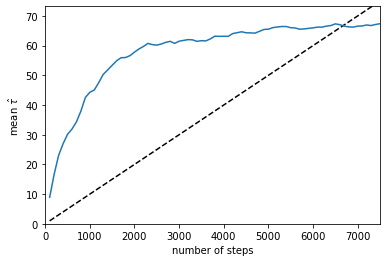

In [7]:
import matplotlib.pyplot as plt

n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

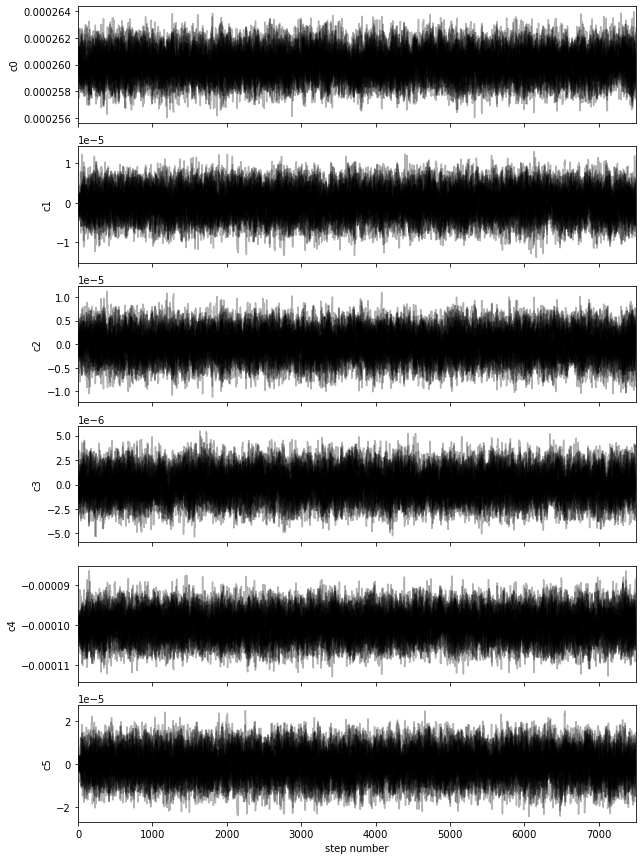

In [8]:
fig, axes = plt.subplots(6, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(f'c{i}')
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [9]:
tau = sampler.get_autocorr_time()
print(tau)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
print(flat_samples.shape)

[72.6792941  63.56519645 71.53101837 66.95621919 64.90351019 64.62116985]
(7584, 6)


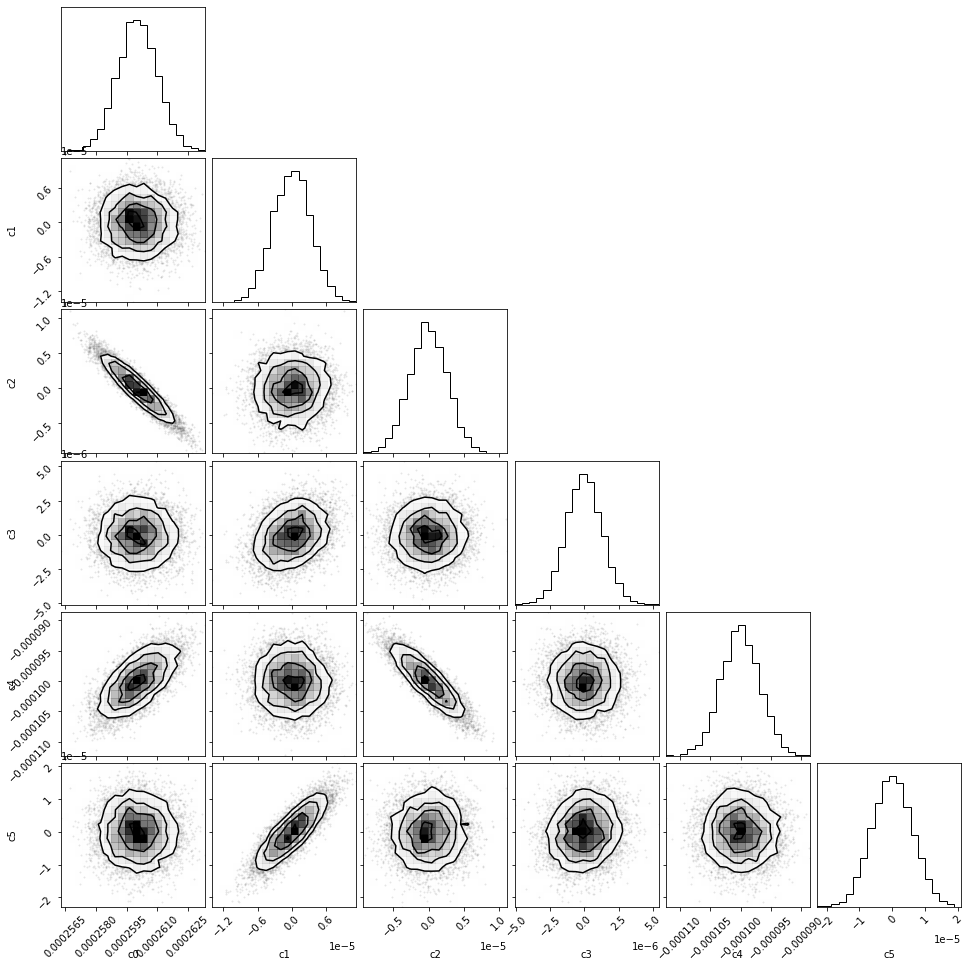

In [10]:
import corner
labels=['c0','c1','c2','c3','c4','c5']
fig = corner.corner(
    flat_samples, labels=labels
);

In [11]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.1e}_{{-{1:.0e}}}^{{{2:.0e}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

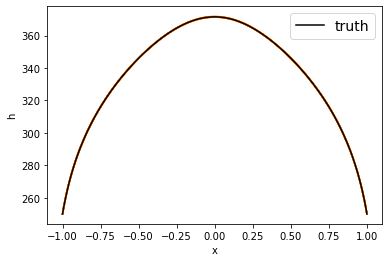

In [12]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, EBM(x, Q, sample, hs, hn, spectral=spectral).solve()/1e3, "C1", alpha=0.1)
plt.plot(x, h/1e3, "k", label="truth")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("h");
